## Cluster assignment model

Poodle assigns a label based on the orientation of the (new) patient in the learned embedding. It does so by creating two distributions for each cluster: 
1. The patient vs cluster similarity (How similar is patient to the cluster?)
2. The within cluster similarity (How stable is the cluster?)

The weight of each of these features is learned on the exploratory set with a ML-technique.
<img style="float: left;" src="../figures/misc/DeployPoodle.png" width="800" height="800" />
  


### Step 1: Quantify sample-cluster similarity


In [29]:
import pandas as pd
import numpy as np
from math import exp
from scipy.stats import ttest_ind
from scipy.spatial.distance import cosine# cosine minkowski
from sklearn.metrics.pairwise import cosine_similarity
import sys
sys.path.append(r'../')
from poodle import utils as pup

# Bookmark probabilities for patient
CLUSTER_LABEL = 'PhenoGraph_clusters'
# Create metadata with fake identifier (use fake)
# Add Original clustering information (same samples as development set)
df_cluster = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv')[[CLUSTER_LABEL]]
df_cluster['pseudoId'] = ['id_' + str(i) for i in range(len(df_cluster))]

# Load learned embedding (shared product space)
z_existent = pd.read_csv('../example_data/embedding/SharedProductSpace_embedding.csv',sep=',')
z_existent = z_existent.loc[:, z_existent.columns != 'pseudoId']

# Initialize similarity matrix
# We only need to calculate the pairwise similarities of the initial space 1 time
sim_matrix = cosine_similarity(z_existent.astype(np.float32))
    
def quantifySimilarity(df_cluster, sim_matrix, CLUSTER_LABEL = 'PhenoGraph_clusters'):
    
    N_CLUSTERS = len(np.unique(df_cluster[CLUSTER_LABEL]))
    
    archetype_columns = ['weight_pval', 'weight_mean', 'weight_sd', 'cluster_mean_pat', 'cluster_sd_pat'] # + latent factors?
    l_col = ['pseudoId', CLUSTER_LABEL]
    for i in range(N_CLUSTERS):
        l_col.extend(['%s_%s' % (col, i) for col in archetype_columns ])
    
    df_characteristics = pd.DataFrame(columns=l_col)
    #df_clustering
    #w_1, w_2, w_3, w_4 = l_weights[0], l_weights[1], l_weights[2], l_weights[3]


    N_CLUSTERS = len(df_cluster[CLUSTER_LABEL].unique())

    # Create trainingsset
    for idx, pat in enumerate(df_cluster['pseudoId']):
        l_row = [df_cluster.iloc[idx]['pseudoId'], df_cluster.iloc[idx][CLUSTER_LABEL]]
        l_prob = []
        l_p = []
        cluster = -1

        #print(N_CLUSTERS)
        for cluster_ix in range(N_CLUSTERS):
            #print('Cluster %s' % cluster_ix)
            # Get the indices of patients from specific cluster
            patient_indices = list(df_cluster[df_cluster[CLUSTER_LABEL]==cluster_ix].index)

            # Add the new patient if not already in cluster
            if idx not in patient_indices: 
                patient_indices.append(idx)


            # Keep seperate list (where we will exclude the patient of interest)
            cluster_indices = patient_indices.copy()
            # Remove patient that you want to predict
            #if idx in cluster_indices: 
            cluster_indices.remove(idx)

            # Create copy of product space
            # Subset similarity matrix on said cluster
            sim_matrix_child = pd.DataFrame(sim_matrix.copy()).loc[patient_indices, patient_indices]

            # Patient vs cluster
            patient_scores = list(sim_matrix_child[idx])
            patient_scores = sorted(patient_scores, reverse=True)
            patient_scores = patient_scores[1:] # remove comparison with self

            # Within cluster
            sim_matrix_child = np.array(pd.DataFrame(sim_matrix_child).loc[cluster_indices, cluster_indices])

            # Keep scores of all unique pairwise distances within cluster
            mask = np.triu(np.ones_like(sim_matrix_child, dtype=np.bool),1) # 1 below diagonal
            cluster_scores = np.array(sim_matrix_child[mask])
            tstat, pval = pup.t_test(patient_scores, cluster_scores, alternative='less')

            # Define predictors (Be aware: we assume a normal distribution)
            pred_0 = pval #pval # H0 = patient is similar to cluster, Ha = patient is not similar
            pred_1 = np.mean(cluster_scores) # average cluster probability
            pred_2 = np.std(cluster_scores) # stability of the cluster
            pred_3 = np.mean(patient_scores) # average patient probability
            pred_4 = np.std(patient_scores) # stability of patient probability

            l_row.extend([pred_0, pred_1, pred_2, pred_3, pred_4])


        df_characteristics.loc[len(df_characteristics)] = l_row
    return df_characteristics

df_characteristics = quantifySimilarity(df_cluster, sim_matrix, CLUSTER_LABEL = 'PhenoGraph_clusters')
    
# Bookmark cluster characteristics
df_characteristics['pseudoId'] = df_cluster['pseudoId'].copy()
df_characteristics[CLUSTER_LABEL] = df_cluster[CLUSTER_LABEL].copy()
df_characteristics.to_csv('../example_data/development/ClusterCharacteristics.csv', index=False, sep=',')
df_characteristics.head()

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,id_0,1,1.018765e-81,0.383355,0.158308,0.193059,0.122824,1.000000e+00,0.455010,0.161357,...,7.355258e-66,0.418410,0.154443,0.219879,0.129681,1.000000e+00,0.315299,0.150796,0.416279,0.148035
1,id_1,3,4.697003e-65,0.383355,0.158308,0.217953,0.129272,4.288155e-31,0.455902,0.161775,...,7.599680e-72,0.418410,0.154443,0.227567,0.115374,3.661784e-01,0.315348,0.150725,0.311197,0.156669
2,id_2,2,2.348539e-28,0.383355,0.158308,0.284389,0.139650,5.418928e-131,0.455902,0.161775,...,9.999996e-01,0.417993,0.154371,0.468715,0.154868,8.936199e-15,0.315299,0.150796,0.235443,0.123394
3,id_3,2,5.502973e-60,0.383355,0.158308,0.242916,0.117019,1.229028e-132,0.455902,0.161775,...,1.000000e+00,0.417958,0.154474,0.472903,0.140423,1.965222e-15,0.315299,0.150796,0.227436,0.131943
4,id_4,0,1.000000e+00,0.382604,0.158085,0.494917,0.151742,2.527040e-133,0.455902,0.161775,...,3.342284e-04,0.418410,0.154443,0.388167,0.135810,9.804394e-13,0.315299,0.150796,0.246298,0.117680


### Step 1.2 Create train & test dataset
Perform a stratified split

In [6]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_characteristics, test_size=0.2,  random_state=28072022) # stratify=df_characteristics['PhenoGraph_clusters'],

df_train.to_csv('../example_data/model/labeler/Labeler_trainingset.csv', index=False, sep=',')
df_test.to_csv('../example_data/model/labeler/Labeler_testset.csv', index=False, sep=',')

## Step 2: Generate Poodle labeler

ToDo: We can use optuna to identify the most optimal configurations for assigning the clusters according to the learned embedding. This is more ideal because you use the (shared) product space directly to inform your predictions. Rather than using a surrogate model that relies on a different technique.

### Step 2.1 Perform a 5 fold CV to train the model

In [5]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('../example_data/model/labeler/Labeler_trainingset.csv', sep=',')
df_test  = pd.read_csv('../example_data/model/labeler/Labeler_testset.csv', sep=',')

TRAIN: [161 162 163 164 165 166 167 168 169 170] TEST: [0 1 2 3 4 5 6 7 8 9]
[16:31:51] WARNING: ../src/learner.cc:576: 
Parameters: { "n_trees" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [161 162 163 164 165 166 167 168 169 170]
[16:31:52] WARNING: ../src/learner.cc:576: 
Parameters: { "n_trees" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [322 323 324 325 326 327 328 329 330 331]
[16:31:53] WARNING: ../src/learner.cc:576: 
Parameters: { "n_trees" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [482 483 484 485 486 487 488 489 490 491]
[16:31:53] WARNING: ../src/learner.cc:576: 
Parameters: { "n_trees" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [642 643 644 645 646 647 648 649 650 651]
[16:31:54] WARNING: ../src/learner.cc:576: 
Parameters: { "n_trees" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[array([7.0610916e-04, 9.9510056e-01, 4.2449823e-04, 3.7688524e-03],
      dtype=float32), array([6.4978027e-04, 4.5732819e-04, 9.9833578e-01, 5.5717805e-04],
      dtype=float32), array([0.0067749 , 0.98811615, 0.00172862, 0.00338034], dtype=float32), array([6.6906452e-04, 1.7073556e-04, 9.9884701e-01, 3.1317479e-04],
      dtype=float32), array([3.5503280e-04, 9.9850225e-01, 2.0888774e-04, 9.3387510e-04],
      dtype=float32), array([4.3343654e-04, 2.2933197e-04, 9.9897695e-01, 3.6031738e-04],
      dtype=float32), array([2.3070849e-04, 9.9865782e-01, 1.3698531e-04, 9.7448012e-04],
      dtype=float32), array([3.1528212e-04, 9.9864811e-01, 1.8954117e-04, 8.4705872e-04],
      dtype=float32), array([2.0771494e-04, 9.9839193e-01, 8.0484163e-04, 5.9548713e-04],
      dtype=float32), array([4.3348919e-04, 9.9802554e-01, 2.6060475e-04, 1.2804143e-03],
      dtype=float32), array([7.7234663e-04, 4.3457054e-04, 9.9782324e-01, 9.6987898e-04],
      dtype=float32), array([0.00213037, 0.993951

Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: 1.00)')

<Figure size 432x288 with 0 Axes>

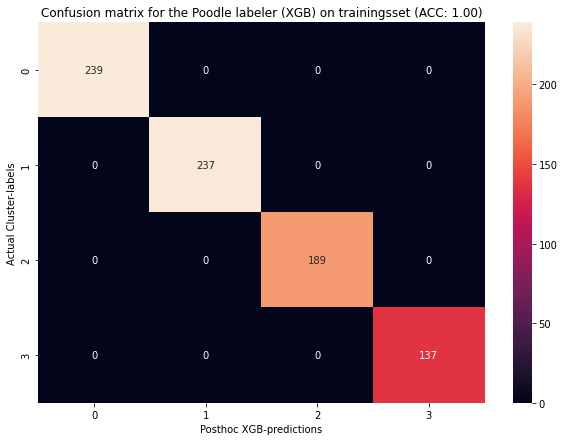

In [8]:
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

target = 'PhenoGraph_clusters'

cols_data = [x for x in list(df_train.columns) if x not in ['pseudoId', target]] #   'Sex', 'Age', 

X = df_train[cols_data].values
y = df_train[target]

# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []
y_proba = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    #print(len(np.take(y,np.array(train_index))))
    y_train, y_test = np.take(y, np.array(train_index)), np.take(y, np.array(test_index))

    # Z-score scaling
    scaler = StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model is an XGBClassifier
    n_trees = 50
    dmat_train = xgb.DMatrix(X_train, y_train)
    dmat_test = xgb.DMatrix(X_test, y_test)
    
    t0 = time.time()
    xgb_clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='merror', num_class=len(y.unique()), n_trees=50)
    xgb_clf = xgb_clf.fit(X_train, y_train)

    

    #bst  = xgb.train({'objective': 'multi:softmax',  'eval_metric':'merror', 'num_class':len(y.unique())}, dmat_train, # 'num_class':len(y.unique())
    #                    n_trees, evals=[(dmat_train, "train")]) # "tree_method": "gpu_hist", 'gamma': 8, , (dmat_test, "test")
    t1 = time.time()
    #print('Time for Training XGB model %s: %s' % (str(iteration+1), str(t1-t0)))
    iteration += 1
    
    # Create a confusion matrix over all data!
    #y_pred.extend(bst.predict(dmat_test))
    y_proba.extend(xgb_clf.predict_proba(X_test))
    y_pred.extend(xgb_clf.predict(X_test))
    
fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)


df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: %.2f)' % (accuracy))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   3.,   1.,
          0.,   0.,   2.,   1.,   0.,   7.,  18., 765.]),
 array([0.3733359 , 0.39420421, 0.41507252, 0.43594083, 0.45680914,
        0.47767745, 0.49854577, 0.51941408, 0.54028239, 0.5611507 ,
        0.58201901, 0.60288732, 0.62375563, 0.64462395, 0.66549226,
        0.68636057, 0.70722888, 0.72809719, 0.7489655 , 0.76983381,
        0.79070212, 0.81157044, 0.83243875, 0.85330706, 0.87417537,
        0.89504368, 0.91591199, 0.9367803 , 0.95764862, 0.97851693,
        0.99938524]),
 <BarContainer object of 30 artists>)

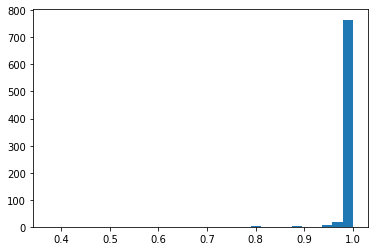

In [20]:
df_probabilities = pd.DataFrame(y_proba)
df_probabilities['Final'] = y_pred
plt.hist(df_probabilities[[0,1,2,3]].max(axis=1), bins=30)

### Step 2.2 Evaluate performance of labeler on an hold-out test set

Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: 1.00)')

<Figure size 432x288 with 0 Axes>

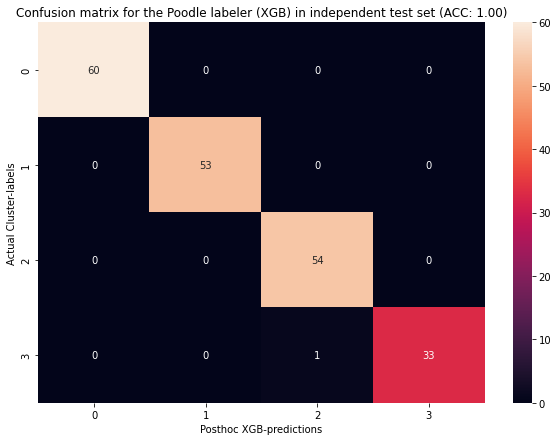

In [11]:
X_test_final = df_test[cols_data].values
y_test_final = df_test[target]

# Z-score scaling
#scaler = StandardScaler().fit(X_test)
X_test_final = scaler.transform(X_test_final)

dmat_blind = xgb.DMatrix(X_test_final, y_test_final)
y_pred_final = bst.predict(dmat_blind)

fig = plt.figure()
cm = confusion_matrix(y_test_final, y_pred_final)
accuracy = accuracy_score(y_test_final, y_pred_final)


df_cm = pd.DataFrame(cm, index = list(range(len(y_test_final.unique()))),
                  columns = list(range(len(y_test_final.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

#### Performance of Dummy (probabilities based solely on p-value)



Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: 0.67)')

<Figure size 432x288 with 0 Axes>

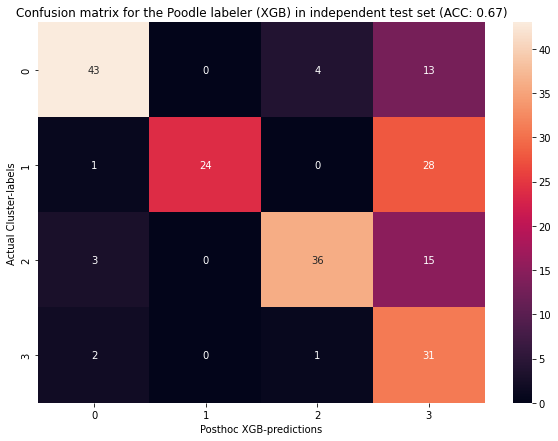

In [13]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
df_test = pd.read_csv('../example_data/model/labeler/Labeler_testset.csv', sep=',')

def dummyLabeler(X):
    return np.argmax(X) # largest p

target = 'PhenoGraph_clusters'

X = df_test[[col for col in df_test.columns if 'weight_pval' in col]].copy()
y = df_test[target]

y_pred = []

for ix in range(len(X)): # loop through patients
    y_pred.append(dummyLabeler(X.iloc[ix]))

fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

### Step 2.3 Train final model on all labeled (original) data

In [20]:
X_all = df_characteristics[cols_data]
y_all = df_characteristics[CLUSTER_LABEL]
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

target = 'PhenoGraph_clusters'

cols_data = [x for x in list(df_train.columns) if x not in ['pseudoId', target]] #   'Sex', 'Age', 

X = df_train[cols_data].values
y = df_train[target]

# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    y_train, y_test = np.take(y, np.array(train_index)), np.take(y, np.array(test_index))

    # Normalize
    fit_gaussian = False

    # Z-score scaling
    scaler = StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model is an XGBClassifier
    n_trees = 50
    dmat_train = xgb.DMatrix(X_train, y_train)
    dmat_test = xgb.DMatrix(X_test, y_test)

    t0 = time.time()
    bst  = xgb.train({'objective': 'multi:softmax',  'eval_metric':'merror', 'num_class':len(y.unique())}, dmat_train, # 'num_class':len(y.unique())
                        n_trees, evals=[(dmat_train, "train")]) # "tree_method": "gpu_hist", 'gamma': 8, , (dmat_test, "test")
    t1 = time.time()
    iteration += 1
    
    # Create a confusion matrix over all data!
    y_pred.extend(bst.predict(dmat_test))

TRAIN: [161 162 163 164 165 166 167 168 169 170] TEST: [0 1 2 3 4 5 6 7 8 9]
[0]	train-merror:0.00156
[1]	train-merror:0.00000
[2]	train-merror:0.00000
[3]	train-merror:0.00000
[4]	train-merror:0.00000
[5]	train-merror:0.00000
[6]	train-merror:0.00000
[7]	train-merror:0.00000
[8]	train-merror:0.00000
[9]	train-merror:0.00000
[10]	train-merror:0.00000
[11]	train-merror:0.00000
[12]	train-merror:0.00000
[13]	train-merror:0.00000
[14]	train-merror:0.00000
[15]	train-merror:0.00000
[16]	train-merror:0.00000
[17]	train-merror:0.00000
[18]	train-merror:0.00000
[19]	train-merror:0.00000
[20]	train-merror:0.00000
[21]	train-merror:0.00000
[22]	train-merror:0.00000
[23]	train-merror:0.00000
[24]	train-merror:0.00000
[25]	train-merror:0.00000
[26]	train-merror:0.00000
[27]	train-merror:0.00000
[28]	train-merror:0.00000
[29]	train-merror:0.00000
[30]	train-merror:0.00000
[31]	train-merror:0.00000
[32]	train-merror:0.00000
[33]	train-merror:0.00000
[34]	train-merror:0.00000
[35]	train-merror:0.000

### Step 2.4 Save poodle labeler & scaler

In [25]:
from pickle import dump

# save poodle labeler
bst.save_model("../example_data/model/labeler/xgb_model.json")

# save scaler
dump(scaler, open('../example_data/model/labeler/scaler.pkl', 'wb'))

### Step 2.5 Load poodle labeler & scaler

In [97]:
from pickle import load

# load model
loaded_bst = xgb.Booster()
loaded_bst.load_model("../example_data/model/labeler/xgb_model.json")

# load the scaler
scaler = load(open('../example_data/model/labeler/scaler.pkl', 'rb'))

### Step 2.6 Show weights for each feature

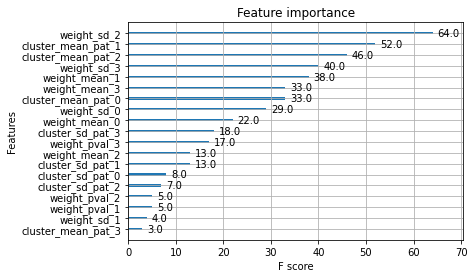

In [98]:
loaded_bst.feature_names = cols_data
xgb.plot_importance(booster=loaded_bst ); 

## Step 3: Deploy on new patients

### Step 3.1 Import datasets

In [1]:
import numpy as np
import pandas as pd

# Load modalities from replication set
df_categoric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_CATEGORICAL.csv', sep=',')
df_numeric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_NUMERIC.csv', sep=',')

# Bookmark identifier (use fake)
df_id = pd.DataFrame({'pseudoId' : ['id_' + str(i) for i in range(len(df_numeric_replication))]})

# Only keep variables eligible for clustering
l_remove = ['pseudoId']
df_categoric_replication = df_categoric_replication[[col for col in df_categoric_replication.columns if col not in l_remove]]
df_numeric_replication = df_numeric_replication[[col for col in df_numeric_replication.columns if col not in l_remove]]

# Original clustering information (same samples as development set)
df_cluster = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv')[['pseudoId', 'PhenoGraph_clusters']]

# Load learned embedding
z_existent = pd.read_csv('../example_data/embedding/SharedProductSpace_embedding.csv',sep=',')
z_existent = z_existent.loc[:, z_existent.columns != 'pseudoId']

### Step 3.2 Initialize variables

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import maui

# Load MAUI model
maui_model = maui.Maui.load('../example_data/model/replication_maui')

# Construct patient similarity matrix from original set
sim_matrix = cosine_similarity(z_existent.astype(np.float32))

# Specify columns for each modality (need to be present in both original & replication space)
d_input = {'cat' : list(df_categoric_replication.columns), 'num' : list(df_numeric_replication.columns)}

# Intialize list to save location of newly projected patients
z_new = []

# Define cluster
CLUSTER_LABEL = 'PhenoGraph_clusters'

# Initialize dataframe where we collect all predictors of interest for assigning patients to a cluster 
archetype_columns = ['weight_pval', 'weight_mean', 'weight_sd', 'cluster_mean_pat', 'cluster_sd_pat'] # + latent factors?
l_col = ['pseudoId', CLUSTER_LABEL]
for i in range(len(np.unique(df_cluster[CLUSTER_LABEL]))):
    l_col.extend(['%s_%s' % (col, i) for col in archetype_columns ])

df_characteristics = pd.DataFrame(columns=l_col)

Using TensorFlow backend.
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

### Step 3.3 Project new patients

In [3]:
import sys
sys.path.append(r'../')
from poodle import utils as pup
np.seterr('raise') # reveal potential floating point errors

for ix, new_pat in enumerate(df_id['pseudoId']):
    # collect sample information
    new_pat = str(df_id.iloc[ix]['pseudoId'])
    sample_cat = df_categoric_replication.iloc[ix]
    sample_num = df_numeric_replication.iloc[ix]
    sample = sample_cat.append(sample_num)
    sample.name = new_pat

    # create metadata
    df_meta = pup.getMetaDataPatient(df_cluster, list(df_cluster['pseudoId'].values), new_pat)
    
    l_orientation = [df_id.iloc[ix]['pseudoId'], -1]
    
    # What is the orientation of the patient compared to each cluster
    # In other words, which cluster has the largest gravity on the patient
    l_orientation.extend(pup.getOrientation(maui_model, df_meta, z_existent, d_input, sample, sim_matrix, cluster_label='PhenoGraph_clusters'))

    # Bookmark cluster characteristics
    df_characteristics.loc[len(df_characteristics)] = l_orientation
    
df_characteristics['pseudoId'] = df_id['pseudoId'].copy()
df_characteristics.to_csv('../example_data/replication/ClusterCharacteristics_Projection.csv', index=False, sep=',')
df_characteristics.head()

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,id_0,-1,0.000001,0.383355,0.158308,0.194458,0.122464,0.999751,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.186558,0.120507,0.999986,0.315299,0.150796,0.368991,0.161582
1,id_1,-1,1.000000,0.383355,0.158308,0.462702,0.160319,0.000001,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.209282,0.132275,0.000001,0.315299,0.150796,0.236356,0.133055
2,id_2,-1,0.000001,0.383355,0.158308,0.218522,0.101966,0.000001,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.378062,0.129064,0.223414,0.315299,0.150796,0.307233,0.136970
3,id_3,-1,0.003712,0.383355,0.158308,0.357222,0.166864,0.000001,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.266956,0.129432,0.921759,0.315299,0.150796,0.330996,0.142882
4,id_4,-1,0.000001,0.383355,0.158308,0.167911,0.120148,0.045268,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.238952,0.115350,0.964240,0.315299,0.150796,0.336006,0.148004


### Step 3.4 Employ poodle labeler on new patients

In [4]:
import sys
sys.path.append(r'../')
from poodle import utils as pup
import pandas as pd

df_new = pd.read_csv('../example_data/replication/ClusterCharacteristics_Projection.csv', sep=',')

# Define input columns
target = 'PhenoGraph_clusters'
cols_data = [x for x in list(df_new.columns) if x not in ['pseudoId', target]]

# Classify patients
X_replication = df_new[cols_data].values
df_new['PhenoGraph_clusters'] = pup.classifyPatient(X_replication, path='../example_data/model/labeler/')
df_new.to_csv('../example_data/results/ClusterAssignment_METEOR.csv', index=False, sep=',')
df_new.head()

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,id_0,1.0,0.000001,0.383355,0.158308,0.194458,0.122464,0.999751,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.186558,0.120507,0.999986,0.315299,0.150796,0.368991,0.161582
1,id_1,0.0,1.000000,0.383355,0.158308,0.462702,0.160319,0.000001,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.209282,0.132275,0.000001,0.315299,0.150796,0.236356,0.133055
2,id_2,1.0,0.000001,0.383355,0.158308,0.218522,0.101966,0.000001,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.378062,0.129064,0.223414,0.315299,0.150796,0.307233,0.136970
3,id_3,1.0,0.003712,0.383355,0.158308,0.357222,0.166864,0.000001,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.266956,0.129432,0.921759,0.315299,0.150796,0.330996,0.142882
4,id_4,1.0,0.000001,0.383355,0.158308,0.167911,0.120148,0.045268,0.455902,0.161775,...,0.000001,0.41841,0.154443,0.238952,0.115350,0.964240,0.315299,0.150796,0.336006,0.148004


Spatial variance in replication set: 	C0= 177; C1= 313; C2= 80; C3= 17
Spatial variance in original set: 	C1= 299; C2= 290; C3= 243; C4= 171


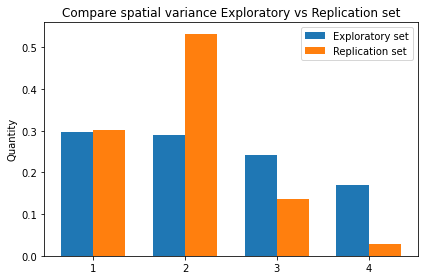

In [5]:
from collections import Counter
from poodle import visualization as viz

c = Counter(df_new['PhenoGraph_clusters'])
l_new = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in replication set: \tC' + '; C'.join([str(ix) + '= ' + str(c[ix]) for ix in range(0,len(c))]))
c = Counter(df_cluster['PhenoGraph_clusters'])
l_old = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in original set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))

viz.plotSpatialVariation(l_new, l_old)

## 4. Alternative Approaches

### Example 1: Hyperparameter tuning 
You may want to perform hyperparameter tuning if you are not able to achieve a decent performance with the default parameters. It might be that you have many labels or that your clusters show little variance. In this case, adjusting the hyperparameters could potentially improve the model

In [17]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
import optuna
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import xgboost as xgb

xgb.config_context(verbosity= 0) # silent
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    
    # Import data
    df_train = pd.read_csv('../example_data/model/labeler/Labeler_trainingset.csv', sep=',')
    
    # Define labels/ input
    target = 'PhenoGraph_clusters'
    cols_data = [x for x in list(df_train.columns) if x not in ['pseudoId', target]] #   'Sex', 'Age', 
    X = df_train[cols_data].values
    y = df_train[target]
    
    # Bookmark all predictions
    y_pred = []
    
    # Perform kfold CV
    # Apply 5 fold CV
    kf = KFold(n_splits=5) 
    
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
        train_x, test_x = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
        train_y, test_y = np.take(y, np.array(train_index)), np.take(y, np.array(test_index))
        
        # Z-score scaling
        scaler = StandardScaler().fit(train_x)
        train_x= scaler.transform(train_x)
        test_x = scaler.transform(test_x)

        dtrain = xgb.DMatrix(train_x, label=train_y)
        dtest = xgb.DMatrix(test_x, label=test_y)

        param = {
            "objective": "multi:softmax",
            'num_class':len(y.unique()),
            "eval_metric": "merror",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
            #"n_trees": 50,
        }

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

        bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], verbose_eval=0) 
        preds = bst.predict(dtest)
        
        # Create a confusion matrix over all data!
        y_pred.extend(bst.predict(dtest))
    
    accuracy = accuracy_score(y, y_pred)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2000, n_jobs=-1) # test # 2000 # -1 -> bootstrapping (take random 100 samples)
print('Best trial: %s' % study.best_trial.number)
print('Performance (accuracy): %s' % study.best_trial.value)
print('Corresponding Parameters: %s' % study.best_trial.params)

/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.



Best trial: 48
Performance (accuracy): 1.0
Corresponding Parameters: {'booster': 'gbtree', 'lambda': 1.921104564130468e-08, 'alpha': 0.003560214587545997, 'max_depth': 5, 'eta': 0.8547768505272534, 'gamma': 0.7742059128991847, 'grow_policy': 'depthwise'}


### Visualize history + parameter space
As you can tell from this figure, hyperparameter tuning is a bit overdoing it in the case of our data. Our performance was already near perfect.

In [19]:
# You can save as static image with kaleido
# pip install -U kaleido

# Identify more important parameters
fig1 = optuna.visualization.plot_param_importances(study)
fig1.write_image("../figures/labeler/param_importances.png") 

# Create contour plot of lambda, alpha
fig2 = optuna.visualization.plot_contour(study, ['lambda', 'alpha'])
fig2.write_image("../figures/labeler/contour_lambda_alpha.png") 

# Show history in performance across iteration (as you can tell it is not difficult to build a good performing labeler in this dataset)
fig3 = optuna.visualization.plot_optimization_history(study)
fig3.write_image("../figures/labeler/optimization_history.png") 

<img style="float: left;" src="../figures/labeler/optimization_history.png" width="800" height="800" />


## Example: train Poodle Labeler with different ML-technique (LigthGBM)

In [ ]:
# LIGHT GRADIENT BOOSTING
from sklearn.metrics import accuracy_score


#Scaling using the Standard Scaler
sc_1=StandardScaler()
sc_1.fit(X)
X_1=pd.DataFrame(sc_1.fit_transform(X))

y_pred = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X_1).loc[train_index], pd.DataFrame(X_1).loc[test_index]
    #print(len(np.take(y,np.array(train_index))))
    y_train, y_test = np.take(y, np.array(train_index)), np.take(y, np.array(test_index))


    
    #train-test-split
    #Converting the dataset in proper LGB format
    d_train=lgb.Dataset(X_train, label=y_train)
    #setting up the parameters
    params={}
    params['learning_rate']=0.03
    params['boosting_type']='gbdt' #GradientBoostingDecisionTree
    params['objective']='multiclass' #Multi-class target feature
    params['metric']='multi_logloss' #metric for multi-class
    params['max_depth']=10
    params['num_class']=4#no.of unique values in the target class not inclusive of the end value
    #training the model
    clf=lgb.train(params,d_train,100)  #training the model on 100 epocs
    #prediction on the test dataset
    y_pred_1=clf.predict(X_test)
    
    #argmax() method 
    y_pred_1 = [np.argmax(line) for line in y_pred_1]
    #printing the predictions
    y_pred.extend(y_pred_1)

fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)


df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))